In [30]:
import numpy as np
import pandas as pd
import pickle
import json
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import os

In [2]:
def save_obj(obj, name ):
    with open('objs/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('objs/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
todaydt = '0807'

In [4]:
origin_data = pd.read_csv('data/epi_initial_new{}.csv'.format(todaydt))

In [5]:
origin_data = origin_data.sort_values(by = 'ID', ascending= True)

In [6]:
origin_data.tail()

,ID,city,population,2020/1/15,2020/1/16,2020/1/17,2020/1/18,2020/1/19,2020/1/20,2020/1/21,...,2020/7/28,2020/7/29,2020/7/30,2020/7/31,2020/8/1,2020/8/2,2020/8/3,2020/8/4,2020/8/5,2020/8/6
0,0,Australia,2460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15306,15583,16304,16906,17283,17923,18318,18733,19444,19862
1,1,South Africa,5652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,459761,471123,482169,493183,503290,511485,516862,521318,529877,538184


In [7]:
city_ID = {}
ID_city = {}
for _, row in origin_data.iterrows():
    city_ID[row['city']] = int(row['ID'])
    ID_city[int(row['ID'])] = row['city']

In [8]:
population = origin_data[['ID', 'city', 'population']]

In [9]:
epidemic = origin_data.drop(['population', ], axis= 1)

In [10]:
epidemic.shape

(2, 207)

In [11]:
epidemic = np.array(epidemic)

In [12]:
cure_origin = pd.read_csv('data/epi_cure_new{}.csv'.format(todaydt))
cure_origin = cure_origin.fillna(0)
cure = np.array(cure_origin.drop(['population', ], axis= 1))

In [13]:
death_origin = pd.read_csv('data/epi_death_new{}.csv'.format(todaydt))
death_origin = death_origin.fillna(0)
death = np.array(death_origin.drop(['population', ], axis= 1))

In [14]:
alldates = list(origin_data.columns)[3:]

In [15]:
population = np.array(population)

In [16]:
def get_ci(predict_value):
    s = np.random.poisson(predict_value, 1000000)
    return np.percentile(s, [2.5, 97.5])

In [28]:
import SEIISR_ode
import scipy.integrate as spi
from scipy.optimize import minimize

def SEIISR_loss(TRUE, PRED):
    return np.sum(np.square((TRUE[:, 0] - TRUE[:, 1]) - (PRED[:, 2] + PRED[:, 3]))) + np.sum(np.square(TRUE[:, 1] - PRED[:, 4]))


def optim_fun_limit(args, originx):
    INPUT, t_range, TRUE = args
    '''
    x[0] = E[0]
    x[1] = beta
    x[2] = sigma
    x[3] = epsilon
    x[4] = _lambda_
    x[5] = gamma
    '''
    v = lambda x: SEIISR_loss(TRUE,
                              spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, (INPUT[0], INPUT[1], INPUT[2], INPUT[3], INPUT[4]), t_range, args = (x[0], x[1], x[2], x[3], x[4], x[5])))
    
    return v

def optim_bnd(N):
    bounds = [(0, None) for i in range(N)]

def optim_con(N):
    con = [{'type': 'ineq', 'fun': lambda x: x[i]}for i in range(N)]

    return con

In [18]:
def predict_Ndays(init_S, infect_data, remove_data, N, E0=None, x0_init = None, k=None):
    S0 = init_S
    I0 = infect_data[0] - remove_data[0]
    R0 = remove_data[0]
    INPUT = (S0, I0 * 2. if E0 is None else E0, 0.0, I0, R0)
    
    
    TRUE = np.array([infect_data,
                     remove_data])
    TRUE = TRUE.T
    S0 = 1. if S0 == 0 else S0
    INPUT = (S0, INPUT[1], 0.0, I0, R0)
    print('E0 = {}'.format(INPUT[1]))
    
    t_range = np.arange(0, len(TRUE), 1)
#     x0 = np.array([5e-9, 7e-9, 1, 0.3, 0.97, 9e-3])
    x0 = np.array([5e-9, 7e-9, 1, 0.3, 0.97, 9e-3]) if x0_init is None else x0_init # 武汉
    print('x0', x0, INPUT)
    r = optim_fun((INPUT, t_range, TRUE))(x0)
    print(r)
    RES = minimize(optim_fun((INPUT, t_range, TRUE)), x0, method = 'Nelder-Mead', options = {'disp': True})

    print(RES.x)

    r = optim_fun((INPUT, t_range, TRUE))(RES.x)
    print(r)

    x = RES.x
    t_range = np.arange(0.0, N, 1.0)
    RES0 = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, (INPUT[0], INPUT[1], INPUT[2], INPUT[3], INPUT[4]), t_range[:len(infect_data)], args = (x[0], x[1], x[2], x[3], x[4], x[5]))
    print(RES0.shape, len(infect_data))
    print(RES0[-1, :])
    
    _lambda_ = max(x[4], 0)
    _lambda_ = min(_lambda_, 1.)
    print(_lambda_)
    
    other_U = max(0, RES0[-1, 2] + RES0[-1, 3] + RES0[-1, 4] - infect_data[-1])
    
    RES0[-1, 4] = remove_data[-1]
    RES0[-1, 3] = _lambda_ * (infect_data[-1] - remove_data[-1])
    RES0[-1, 2] = (1-_lambda_) * (infect_data[-1] - remove_data[-1])
#     RES0[-1, 2] = 0
    RES0[-1, 1] += other_U

    
    RES1 = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, RES0[-1, :], t_range[len(infect_data)-1:], args = (x[0], x[1], x[2], x[3], x[4], x[5]))
    RES = np.concatenate((RES0[:-1, :], RES1))
    print(RES.shape)

    PRED = RES[:, 2] + RES[:, 3] + RES[:, 4] # I +IS + R
    
    return PRED, {'S': RES[:, 0], 'E': RES[:, 1], 'I+IS': RES[:, 2] + RES[:, 3], 'R': RES[:, 4], 'I+IS+R': PRED, 'ACTUAL_ALL': PRED+RES[:, 1]}

In [19]:
def predict_Ndays_part(init_S, infect_data, remove_data, N, E0=None, x0_init = None, x0_fix = None, k=None):
    S0 = init_S
    I0 = infect_data[0] - remove_data[0]
    R0 = remove_data[0]
    INPUT1 = (S0, I0 * 15. if E0 is None else E0, 0.0, I0, R0)
    
    
    TRUE = np.array([infect_data,
                     remove_data])
    TRUE = TRUE.T
    S0 = 1. if S0 == 0 else S0
    INPUT1 = (S0, INPUT1[1], 0.0, I0, R0)
    print('E0 = {}'.format(INPUT1[1]))
    
    k=-19 if k is None else k # wh -9 qg-5 -6
    TRUE1 = TRUE[:k, :]
    TRUE2 = TRUE[k-1:, :]
    
#     INPUT1 = (9e6, 12895 - 433, 0.0, 433 - 57, 57)
#     TRUE1 = np.array([[ 698, 1590, 1905, 2261, 2639, 3215, 4109],
#                      [ 105, 132, 151, 180, 231, 315, 379]])
#     TRUE1 = TRUE1.T
    print(TRUE1, len(TRUE1))
    
    t_range1 = np.arange(0, len(TRUE1), 1)
    x0 = np.array([5e-9, 7e-9, 1, 0.3, 0.97, 9e-3]) if x0_init is None else x0_init # 武汉
    print('x0', x0, INPUT1)
    r = optim_fun((INPUT1, t_range1, TRUE1))(x0)
    print(r)
    RES = minimize(optim_fun((INPUT1, t_range1, TRUE1)), x0, method = 'Nelder-Mead', options = {'disp': True})
    
    print(TRUE2)
    originx = RES.x
    print('before', RES.x)
    x = RES.x
    RES0 = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, (INPUT1[0], INPUT1[1], INPUT1[2], INPUT1[3], INPUT1[4]), t_range1, args = (x[0], x[1], x[2], x[3], x[4], x[5]))
    
    t_range2 = np.arange(0, len(TRUE2), 1)
    INPUT2 = RES0[-1, :]
    
    RES2 = minimize(optim_fun_limit((INPUT2, t_range2, TRUE2), originx), originx, method = 'Nelder-Mead', options = {'disp': True})
    r = optim_fun_limit((INPUT2, t_range2, TRUE2), originx)(RES2.x)
    print(r)

    x = originx
    t_range = np.arange(0.0, N, 1.0)
    
    RES1 = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, (INPUT1[0], INPUT1[1], INPUT1[2], INPUT1[3], INPUT1[4]), t_range[:len(TRUE1)], args = (x[0], x[1], x[2], x[3], x[4], x[5]))
    
#     x[3] = RES2.x[3]
    x = RES2.x
    print('after ', x)
    RES2 = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, RES1[-1, :], t_range[len(TRUE1)-1:len(infect_data)], args =  (x[0], x[1], x[2], x[3], x[4], x[5]))
    RES = np.concatenate((RES1[:-1, :], RES2))
    print(RES.shape, len(infect_data))
    
    _lambda_ = max(x[4], 0)
    _lambda_ = min(_lambda_, 1.)
    print(_lambda_)
    
    print(RES[-1, :])
    
    other_U = max(0, RES[-1, 2] + RES[-1, 3] + RES[-1, 4] - infect_data[-1])
    
    RES[-1, 4] = remove_data[-1]
    RES[-1, 3] =  (infect_data[-1] - remove_data[-1])
#     RES[-1, 2] = (1-_lambda_) * (infect_data[-1] - remove_data[-1])
    RES[-1, 2] = 0
    RES[-1, 1] += other_U
    print(RES[-1, :])
    
    RES3 = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, RES[-1, :], t_range[len(infect_data)-1:], args =  (x[0], x[1], x[2], x[3], x[4], x[5]))
    
    RES = np.concatenate((RES[:-1, :], RES3))
    print(RES.shape)

#     RES = spi.odeint(SEIISR_ode.SEIISR_v_base_eqs, (INPUT[0], INPUT[1], INPUT[2], INPUT[3], INPUT[4]), t_range, args = (x[0], x[1], x[2], x[3], x[4], x[5]))

    PRED = RES[:, 2] + RES[:, 3] + RES[:, 4] # I +IS + R
    
    return PRED, {'S': RES[:, 0], 'E': RES[:, 1], 'I+IS': RES[:, 2] + RES[:, 3], 'R': RES[:, 4], 'I+IS+R': PRED, 'ACTUAL_ALL': PRED+RES[:, 1]}

In [20]:
params = {}

In [21]:
today = alldates[-1]

In [22]:
def str_to_dt(datestr):
    return dt.datetime.strptime(datestr, '%Y/%m/%d').date()
def dt_to_str(datedt):
    return datedt.strftime('%Y/%m/%d')

In [23]:
alldates_dt = [dt.datetime.strptime(d, '%Y/%m/%d').date() for d in alldates]
today_dt = alldates_dt[-1]

In [24]:
from scipy.signal import savgol_filter
def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='same')
    yhat = savgol_filter(y, box_pts, 1)
    return yhat
# PRED_ALL[:len(infect_data) + 3] = smooth(PRED_ALL[:len(infect_data) + 3], 5)

In [25]:
def fix_PRED(PRED_ALL, days = 3):
    xPRED = [PRED_ALL[0],] + list(np.diff(PRED_ALL))
    minind = np.argmin(xPRED)
    if xPRED[minind] >= 0:
        return PRED_ALL
    sums = np.sum([xPRED[minind - i - 1] for i in range((days))])
    fix = 1.08192 - xPRED[minind]
    rates = [xPRED[minind - i - 1] / sums for i in range((days))]
    fixs = fix * np.array(rates)
    xPRED[minind] = 1.08192
    for i in range((days)):
        xPRED[minind-i-1] -= fixs[i]
    PRED_ALL2 = np.array(xPRED).cumsum()
    return PRED_ALL2
# PRED_ALL = fix_PRED(PRED_ALL, days=7)

South Africa
Infect: [276242 287796 298292 311049 324221 337594 350879 364328 373628 381798
 394948 408052 421996 434200 445433 452529 459761 471123 482169 493183
 503290 511485 516862 521318 529877 538184]
Remove: [138953 142413 150625 165146 170260 182987 187178 196092 200038 213512
 235115 242353 252114 269709 271846 281992 294570 305464 317413 334176
 350614 355593 366576 372635 386564 396920]
E0 = 88086
[[276242 138953]
 [287796 142413]
 [298292 150625]
 [311049 165146]
 [324221 170260]
 [337594 182987]
 [350879 187178]] 7
x0 [1.0e-06 9.0e-07 1.0e+01 3.0e-01 9.5e-01 9.0e-03] (399000, 88086, 0.0, 137289, 138953)
11671852270.70097


C:\Users\Dell\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Optimization terminated successfully.
         Current function value: 87135313.722193
         Iterations: 414
         Function evaluations: 836
[[350879 187178]
 [364328 196092]
 [373628 200038]
 [381798 213512]
 [394948 235115]
 [408052 242353]
 [421996 252114]
 [434200 269709]
 [445433 271846]
 [452529 281992]
 [459761 294570]
 [471123 305464]
 [482169 317413]
 [493183 334176]
 [503290 350614]
 [511485 355593]
 [516862 366576]
 [521318 372635]
 [529877 386564]
 [538184 396920]]
before [ 1.18290811e-06 -1.87324478e-06  3.85912356e+00  1.52774149e-01
 -2.76102226e+00  5.53145367e-02]
Optimization terminated successfully.
         Current function value: 831337959.706901
         Iterations: 265
         Function evaluations: 467
831337959.7069013
after  [ 2.80702414e-07 -2.41477299e-06  2.85031716e+00  1.60793918e-01
 -3.17076653e+00  6.64997307e-02]
(26, 5) 26
0
[179951.65991373  45176.05875058 117358.62731163  27846.46673379
 392995.18729027]
[179951.65991373  45192.34008627      

C:\Users\Dell\Miniconda3\envs\py36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


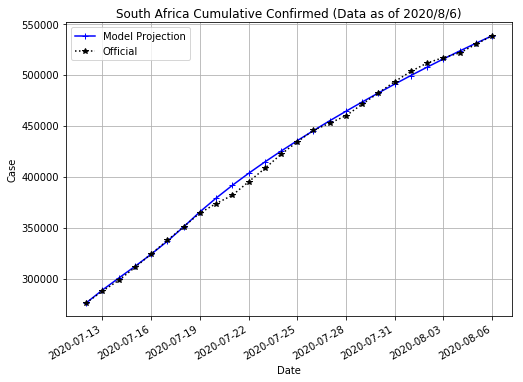

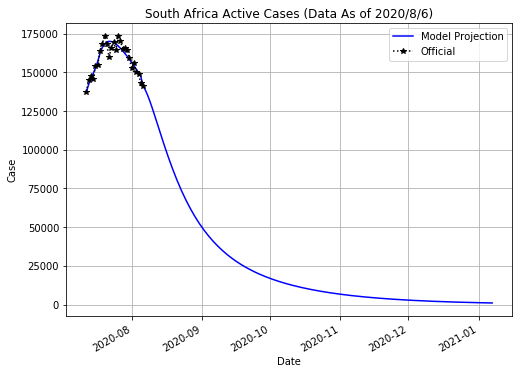

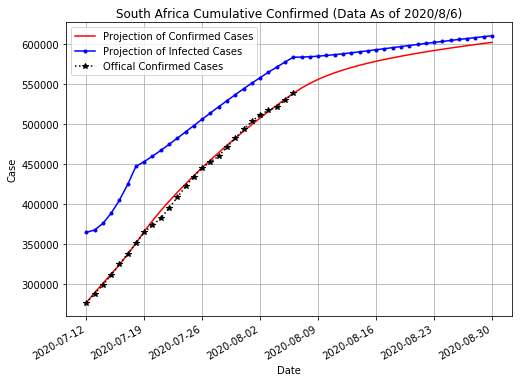

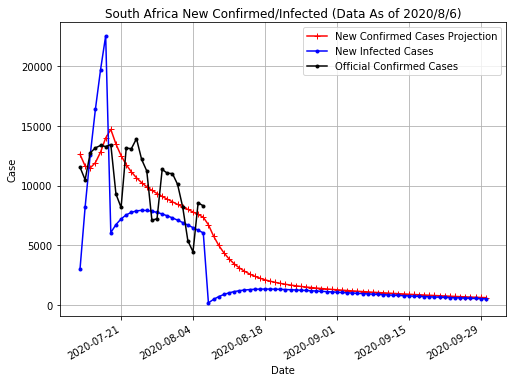

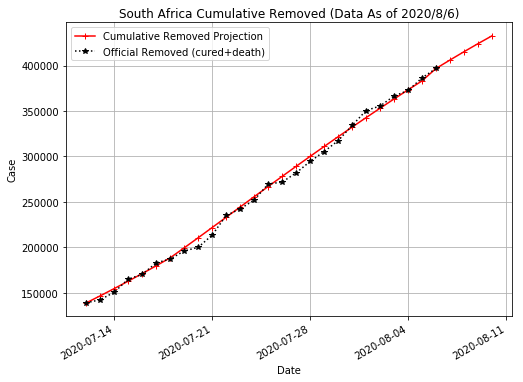

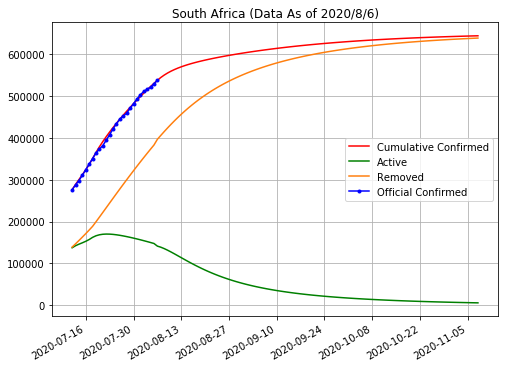

In [31]:
params['South Africa'] = np.array([1e-6, 9e-7, 10, 0.3, 0.95, 9e-3]) 
select_city = ['South Africa']
for cityname in select_city:
    startdate = '2020/7/12' # 24
    print(cityname)
    cityid = city_ID[cityname]
    init_S = 399000 
    greater = np.sum(epidemic[cityid, 2:] > 0)
    window = max(7, greater)
    window = min(window, len(alldates) - alldates.index(startdate)) #wuhan 23
    infect_data = epidemic[cityid, -window:]
    cure_data = cure[cityid, -window:]
    death_data = death[cityid, -window:]
    
    remove_data = cure_data + death_data
    print('Infect:', infect_data)
    print('Remove:', remove_data)

    try:
        x0 = params[cityname]
    except:
        x0 = None
        
    predict_func = predict_Ndays_part
        
    E0=infect_data[7] - infect_data[0]
        
    NN = 240
    PRED_ALL, data_all = predict_func(init_S, infect_data, remove_data, NN, x0_init=x0, E0=E0)
#     PRED_ALL[:len(infect_data) + 5] = smooth(PRED_ALL[:len(infect_data) + 5], 5)
    PRED = PRED_ALL[:len(infect_data)+3]
    ACTUAL_ALL = data_all['ACTUAL_ALL']
    #, _ = predict_Ndays(init_S, infect_data, remove_data, len(infect_data)+3, x0_init=x0)
    based_time = str_to_dt(alldates[-window])
    t_range_subdt = [based_time + dt.timedelta(days = x) for x in range(NN)]
    
    disp_days = 26

    path = './{}_result/overseas/'.format( str(dt.datetime.today().date()))
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'b+-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Projection", "Official"])
    plt.title(u'{} Cumulative Confirmed (Data as of {})'.format(cityname, alldates[-1]))
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    plt.savefig(path+'{}_accum_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 180
    REMOVE_ALL = data_all['R']
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days] - REMOVE_ALL[:disp_days], 'b-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data - remove_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Projection", "Official"],)
    plt.title(u'{} Active Cases (Data As of {})'.format(cityname, alldates[-1]),)
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    plt.savefig(path+'{}_remained_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 50
    
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'r-')
    plt.plot(t_range_subdt[:disp_days], ACTUAL_ALL[:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, "k*:")
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Projection of Confirmed Cases", 'Projection of Infected Cases', 'Offical Confirmed Cases'], )
    plt.title(u'{} Cumulative Confirmed (Data As of {})'.format(cityname, alldates[-1]), )
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    # plt.savefig('0129/{}-0129.pdf'.format(cityname))
    plt.show()
    
    disp_days = 80
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[1:][:disp_days], [PRED_ALL[i+1] - PRED_ALL[i] for i in range(len(PRED_ALL)-1)][:disp_days], 'r+-')
    plt.plot(t_range_subdt[1:][:disp_days], [ACTUAL_ALL[i+1] - ACTUAL_ALL[i] for i in range(len(ACTUAL_ALL)-1)][:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)][1:], [infect_data[i+1] - infect_data[i] for i in range(len(infect_data)-1)], 'k.-')
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["New Confirmed Cases Projection", "New Infected Cases", 'Official Confirmed Cases'], )
    plt.title(u'{} New Confirmed/Infected (Data As of {})'.format(cityname, alldates[-1]), )
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    # plt.savefig('0129/{}-0129.pdf'.format(cityname))
    plt.show()
    
    disp_days = 30
    REMOVE_ALL = data_all['R']
    
    fig3 = plt.figure(figsize=(8,6))
    ax3 = fig3.add_subplot(1,1,1)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.xticks(pd.date_range(t_range_subdt[0],t_range_subdt[disp_days],15), rotation = 40)
    plt.plot(t_range_subdt[:disp_days], REMOVE_ALL[:disp_days], 'r+-')
#     plt.plot(t_range_subdt[:disp_days], ACTUAL_ALL[:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)], remove_data, "k*:")
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(['Cumulative Removed Projection', 'Official Removed (cured+death)'], )
    plt.title(u'{} Cumulative Removed (Data As of {})'.format(cityname, alldates[-1]), )
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}-accumulated.jpg'.format(cityname))
    plt.show()
    
    disp_days = 120
    plt.figure(figsize = (8, 6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'r', label = 'Cumulative Confirmed')
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days] - REMOVE_ALL[:disp_days], 'g', label = 'Active')
    plt.plot(t_range_subdt[:disp_days], REMOVE_ALL[:disp_days], 'tab:orange', label = 'Removed')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, 'b.-', label = 'Official Confirmed')
    plt.legend()
    plt.grid(True)
    plt.title(u'{} (Data As of {})'.format(cityname, alldates[-1]))
    plt.gcf().autofmt_xdate()
    plt.savefig(path+'{}-document_{}days.jpg'.format(cityname, disp_days))
    plt.show()
    
    result = pd.DataFrame(data={
        'Date': [dt_to_str(x) for x in t_range_subdt][:len(PRED_ALL)],
        'Predict_confirm': PRED_ALL, #预测确诊数
        'Predict_actual': ACTUAL_ALL, #预测实际感染数
        'Dailynew_confirm': ([0. ]+[PRED_ALL[i+1] - PRED_ALL[i] for i in range(0, len(PRED_ALL)-1)]),
        'Dailynew_actual': ([0. ]+[ACTUAL_ALL[i+1] - ACTUAL_ALL[i] for i in range(0, len(ACTUAL_ALL)-1)]),
        'Remove': REMOVE_ALL, #移除数
        'Dailynew_remove': ([0. ]+[REMOVE_ALL[i+1] - REMOVE_ALL[i] for i in range(0, len(REMOVE_ALL)-1)]),
        'Remain_confirm': PRED_ALL - REMOVE_ALL,
#         'Confirm_interval_down': [get_ci(x)[0] for x in PRED_ALL],
#         'Confirm_interval_up': [get_ci(x)[1] for x in PRED_ALL],
#         'Actual_interval_down': [get_ci(x)[0] for x in ACTUAL_ALL], # 累计感染置信区间下界
#         'Actual_interval_up': [get_ci(x)[1] for x in ACTUAL_ALL], # 累计感染置信区间上界
    })
    additional = pd.DataFrame(data = {
        'ADate': t_range_subdt[:len(infect_data)],
        'Official_confirmed': infect_data,
        'Official_dailynew': ([0.] + [infect_data[i+1] - infect_data[i] for i in range(0, len(infect_data)-1)]),
        'Official_cure': cure_data,
        'Official_remove': remove_data,
    })
    result = pd.concat([result, additional], axis = 1)
    
    path = './{}_result/overseas/'.format( str(dt.datetime.today().date()))
    if not os.path.exists(path):
        os.makedirs(path)
    result.to_csv(path+'{}_result_{}.csv'.format(cityname,  str(dt.datetime.today().date())), index=False)
    
    print()

Australia
Infect: [9361 9557 9812 9993 10263 10505 10818 11250 11441 11823 12081 12443 12896
 13306 13595 13950 14403 14935 15306 15583 16304 16906 17283 17923 18318
 18733 19444 19862]
Remove: [7733 7831 7836 7877 7945 8039 8149 8234 8281 8397 8518 8670 8781 8908
 9069 9162 9325 9472 9598 9795 9949 10179 10403 10632 10843 11029 11188
 11401]
E0 = 1889
x0 [1.0e-06 9.0e-07 1.0e+01 3.0e-01 9.5e-01 9.0e-03] (85000, 1889, 0.0, 1628, 7733)
246471145.18772566


C:\Users\Dell\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[-2.64652713e-10  1.91712797e-06 -1.16050948e+01  1.14175978e-01
 -6.70835419e-01  3.00843764e-02]
203219.53569431714
(28, 5) 28
[71069.93927468  5159.36878973  7776.31803565   722.58089825
 11521.7930017 ]
0
(240, 5)


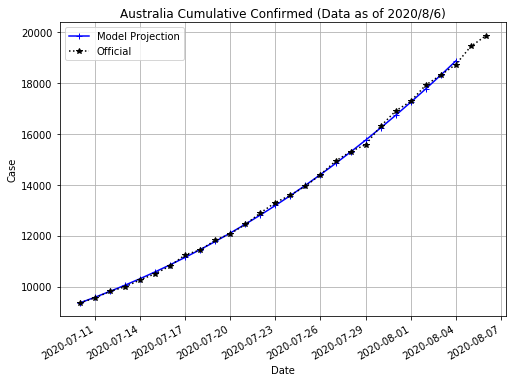

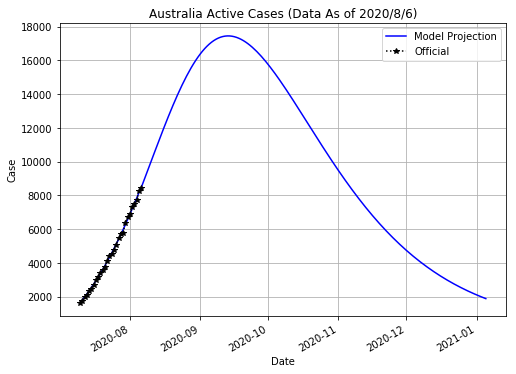

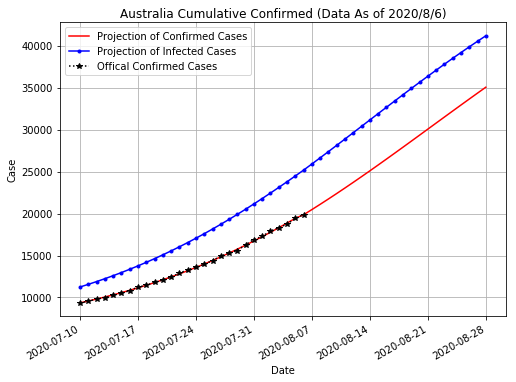

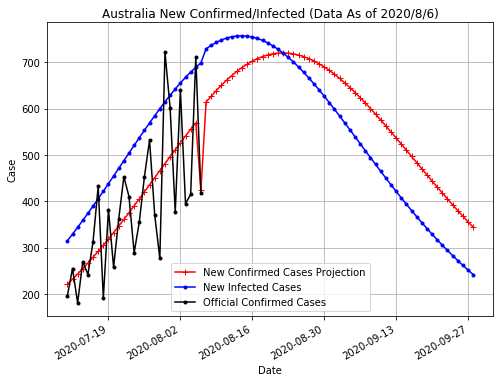

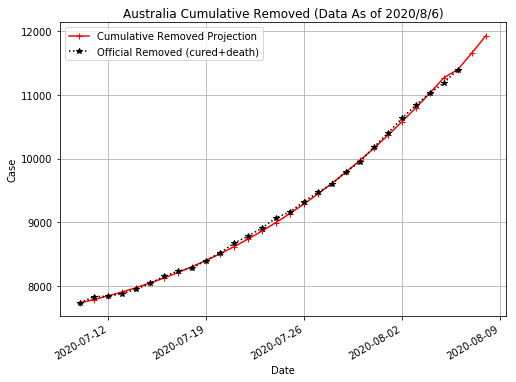

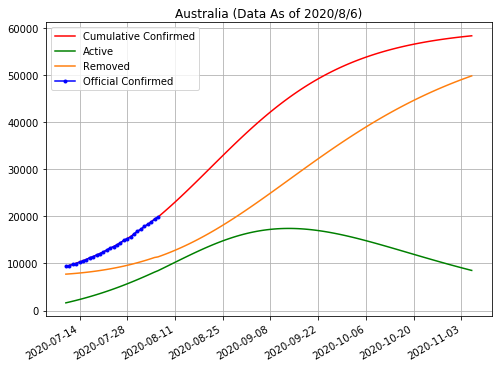

In [33]:
params['Australia'] = np.array([1e-6, 9e-7, 10, 0.3, 0.95, 9e-3]) 
select_city = ['Australia']
for cityname in select_city:
    startdate = '2020/7/10' # 24
    print(cityname)
    cityid = city_ID[cityname]
    init_S = 85000 
    greater = np.sum(epidemic[cityid, 2:] > 0)
    window = max(7, greater)
    window = min(window, len(alldates) - alldates.index(startdate)) #wuhan 23
#     window = min(8, window)
    infect_data = epidemic[cityid, -window:]
    cure_data = cure[cityid, -window:]
    death_data = death[cityid, -window:]
    
    remove_data = cure_data + death_data
    print('Infect:', infect_data)
    print('Remove:', remove_data)

    try:
        x0 = params[cityname]
    except:
        x0 = None
        
    predict_func = predict_Ndays
        
    E0= infect_data[7]- infect_data[0]

    NN = 240
    PRED_ALL, data_all = predict_func(init_S, infect_data, remove_data, NN, x0_init=x0, E0=E0)
#     PRED_ALL[:len(infect_data) + 5] = smooth(PRED_ALL[:len(infect_data) + 5], 5)
    PRED = PRED_ALL[:len(infect_data)+3]
    ACTUAL_ALL = data_all['ACTUAL_ALL']
    #, _ = predict_Ndays(init_S, infect_data, remove_data, len(infect_data)+3, x0_init=x0)
    
    based_time = str_to_dt(alldates[-window])
    t_range_subdt = [based_time + dt.timedelta(days = x) for x in range(NN)]
    
    
    disp_days = 26
    

    path = './{}_result/overseas/'.format( str(dt.datetime.today().date()))
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'b+-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Projection", "Official"])
    plt.title(u'{} Cumulative Confirmed (Data as of {})'.format(cityname, alldates[-1]))
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    plt.savefig(path+'{}_accum_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 180
    REMOVE_ALL = data_all['R']
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days] - REMOVE_ALL[:disp_days], 'b-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data - remove_data, "k*:")
    plt.grid("True")
    plt.legend(["Model Projection", "Official"],)
    plt.title(u'{} Active Cases (Data As of {})'.format(cityname, alldates[-1]),)
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    plt.savefig(path+'{}_remained_confirmed_day{}.jpg'.format(cityname, disp_days), dpi=200)
    plt.show()
    
    disp_days = 50
    
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'r-')
    plt.plot(t_range_subdt[:disp_days], ACTUAL_ALL[:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, "k*:")
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["Projection of Confirmed Cases", 'Projection of Infected Cases', 'Offical Confirmed Cases'], )
    plt.title(u'{} Cumulative Confirmed (Data As of {})'.format(cityname, alldates[-1]), )
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    # plt.savefig('0129/{}-0129.pdf'.format(cityname))
    plt.show()
    
    disp_days = 80
    plt.figure(figsize=(8,6))
    plt.plot(t_range_subdt[1:][:disp_days], [PRED_ALL[i+1] - PRED_ALL[i] for i in range(len(PRED_ALL)-1)][:disp_days], 'r+-')
    plt.plot(t_range_subdt[1:][:disp_days], [ACTUAL_ALL[i+1] - ACTUAL_ALL[i] for i in range(len(ACTUAL_ALL)-1)][:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)][1:], [infect_data[i+1] - infect_data[i] for i in range(len(infect_data)-1)], 'k.-')
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(["New Confirmed Cases Projection", "New Infected Cases", 'Official Confirmed Cases'], )
    plt.title(u'{} New Confirmed/Infected (Data As of {})'.format(cityname, alldates[-1]), )
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
    # plt.savefig('0129/{}-0129.pdf'.format(cityname))
    plt.show()
    
    disp_days = 30
    REMOVE_ALL = data_all['R']
    
    fig3 = plt.figure(figsize=(8,6))
    ax3 = fig3.add_subplot(1,1,1)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.xticks(pd.date_range(t_range_subdt[0],t_range_subdt[disp_days],15), rotation = 40)
    plt.plot(t_range_subdt[:disp_days], REMOVE_ALL[:disp_days], 'r+-')
#     plt.plot(t_range_subdt[:disp_days], ACTUAL_ALL[:disp_days], 'b.-')
    plt.plot(t_range_subdt[:len(infect_data)], remove_data, "k*:")
#     plt.plot(t_range_dt[:len(infect_data)], infect_data, "k*:")
    plt.grid("True")
    plt.legend(['Cumulative Removed Projection', 'Official Removed (cured+death)'], )
    plt.title(u'{} Cumulative Removed (Data As of {})'.format(cityname, alldates[-1]), )
    plt.xlabel('Date')
    plt.ylabel('Case')
    plt.gcf().autofmt_xdate()
#     plt.savefig(path+'{}-accumulated.jpg'.format(cityname))
    plt.show()
    
    disp_days = 120
    plt.figure(figsize = (8, 6))
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days], 'r', label = 'Cumulative Confirmed')
    plt.plot(t_range_subdt[:disp_days], PRED_ALL[:disp_days] - REMOVE_ALL[:disp_days], 'g', label = 'Active')
    plt.plot(t_range_subdt[:disp_days], REMOVE_ALL[:disp_days], 'tab:orange', label = 'Removed')
    plt.plot(t_range_subdt[:len(infect_data)], infect_data, 'b.-', label = 'Official Confirmed')
    plt.legend()
    plt.grid(True)
    plt.title(u'{} (Data As of {})'.format(cityname, alldates[-1]))
    plt.gcf().autofmt_xdate()
    plt.savefig(path+'{}-document_{}days.jpg'.format(cityname, disp_days))
    plt.show()
    
    result = pd.DataFrame(data={
        'Date': [dt_to_str(x) for x in t_range_subdt][:len(PRED_ALL)],
        'Predict_confirm': PRED_ALL, #预测确诊数
        'Predict_actual': ACTUAL_ALL, #预测实际感染数
        'Dailynew_confirm': ([0. ]+[PRED_ALL[i+1] - PRED_ALL[i] for i in range(0, len(PRED_ALL)-1)]),
        'Dailynew_actual': ([0. ]+[ACTUAL_ALL[i+1] - ACTUAL_ALL[i] for i in range(0, len(ACTUAL_ALL)-1)]),
        'Remove': REMOVE_ALL, #移除数
        'Dailynew_remove': ([0. ]+[REMOVE_ALL[i+1] - REMOVE_ALL[i] for i in range(0, len(REMOVE_ALL)-1)]),
        'Remain_confirm': PRED_ALL - REMOVE_ALL,
#         'Confirm_interval_down': [get_ci(x)[0] for x in PRED_ALL],
#         'Confirm_interval_up': [get_ci(x)[1] for x in PRED_ALL],
#         'Actual_interval_down': [get_ci(x)[0] for x in ACTUAL_ALL], # 累计感染置信区间下界
#         'Actual_interval_up': [get_ci(x)[1] for x in ACTUAL_ALL], # 累计感染置信区间上界
    })
    additional = pd.DataFrame(data = {
        'ADate': t_range_subdt[:len(infect_data)],
        'Official_confirmed': infect_data,
        'Official_dailynew': ([0.] + [infect_data[i+1] - infect_data[i] for i in range(0, len(infect_data)-1)]),
        'Official_cure': cure_data,
        'Official_remove': remove_data,
    })
    result = pd.concat([result, additional], axis = 1)
    
    path = './{}_result/overseas/'.format( str(dt.datetime.today().date()))
    if not os.path.exists(path):
        os.makedirs(path)
    result.to_csv(path+'{}_result_{}.csv'.format(cityname,  str(dt.datetime.today().date())), index=False)
    
    print()